# Data Science Case
Mindbody manages a marketplace where consumers can search for and purchase class packs directly from studios.  

We are interested in exploring creating discounted offers for new consumers, specifically 15% off first pack to increase awareness and demand for our customers. Raw Data is the results of the experiment. 

- Analyze and present your findings in a powerpoint with visualizations and statistical findings. What are your recommendations, assuming 80% power? Would you say price is elastic? 

- What are your recommendations if we were to recommend a 25% discount, all other things equal? What additional pieces of information would you need to improve your recommendations?

- Please submit any notebooks, scripts, and analysis generated

## Data Dictionary
- Company ID: Unique ID corresponding to a studio/company
- Period: If data corresponds to pre-test or post-test
- Test Cohort: Control - no discount; Test - 15% discount
- Pack Views: Count of Views to the pack purchase page
- Purchases: Count of Purchases made during period
- Market Standard Pack Price: Cost of a pack, pre-discount

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Data Analysis
import pandas as pd
import numpy as np
import pandas as pd
import sys
import seaborn as sns
from matplotlib import pyplot as plt

# Modeling
import statsmodels.api as sm
from pygam import GAM, ExpectileGAM, s, l, f
from sklearn.preprocessing import LabelEncoder

# Visualization
import plotly.express as px
from plotnine import *

# import pytimetk as tk
import textwrap
import sys

sys.path.append("../")
from src.config import config
from src import plots

In [3]:
raw_df = pd.read_excel(
    config.RAW_DATA_PATH / \
    'Data_Scientist_Pricing_Take_Home_-_Candidate_Copy.xlsx',
    sheet_name='Raw Data'
)

data = raw_df.copy()
data.columns = [col.replace(' ', '_').lower() for col in data.columns]

In [4]:
def get_offered_discount(row):
    if row['test_cohort'] == 'Control' or row['period'] == 'Pre':
        return 0
    elif row['period'] == 'Post' and row['test_cohort'] == 'Test':
        return 0.15

In [5]:
data['conversion_rate'] = (data['purchases']/data['pack_views']).round(2)
data['offered_discount'] = data.apply(get_offered_discount, axis=1)

data['final_price'] = data['market_standard_pack_price'] * (1 - data['offered_discount'])
data['revenue'] = data['purchases'] * data['final_price']
data['is_test'] = data['test_cohort'].apply(lambda x: 1 if x == 'Test' else 0)

In [6]:
data.head(10)

,company_id,period,test_cohort,pack_views,purchases,market_standard_pack_price,conversion_rate,offered_discount,final_price,revenue,is_test
0,135,Pre,Test,885,136,10,0.15,0.0,10.0,1360.0,1
1,108,Pre,Test,780,220,10,0.28,0.0,10.0,2200.0,1
2,123,Pre,Test,700,68,10,0.10,0.0,10.0,680.0,1
3,106,Pre,Test,1043,96,10,0.09,0.0,10.0,960.0,1
4,136,Pre,Test,294,161,10,0.55,0.0,10.0,1610.0,1
5,191,Pre,Test,1511,782,10,0.52,0.0,10.0,7820.0,1
6,190,Pre,Test,547,246,10,0.45,0.0,10.0,2460.0,1
7,113,Pre,Test,1486,650,10,0.44,0.0,10.0,6500.0,1
8,167,Pre,Test,1819,747,10,0.41,0.0,10.0,7470.0,1
9,198,Pre,Test,2446,993,10,0.41,0.0,10.0,9930.0,1


## Outliers

In [7]:
# using z-score to find outliers within period and test_cohort groups
data['pack_views_z_score'] = data\
    .groupby(['period', 'test_cohort'])\
    ['pack_views']\
    .transform(lambda x: (x - x.mean()) / x.std())

data['purchases_z_score'] = data\
    .groupby(['period', 'test_cohort'])\
    ['purchases']\
    .transform(lambda x: (x - x.mean()) / x.std())

In [8]:
data[data['pack_views_z_score'].abs() > 3]

,company_id,period,test_cohort,pack_views,purchases,market_standard_pack_price,conversion_rate,offered_discount,final_price,revenue,is_test,pack_views_z_score,purchases_z_score


In [9]:
data[data['purchases_z_score'].abs() > 3]

,company_id,period,test_cohort,pack_views,purchases,market_standard_pack_price,conversion_rate,offered_discount,final_price,revenue,is_test,pack_views_z_score,purchases_z_score


## Raevenue distribution among groups

In [10]:
general_stats = data.groupby(['period', 'test_cohort'])\
    .agg(
        n_companies = ('company_id', 'nunique'),
        total_pack_views = ('pack_views', 'sum'),
        total_purchases = ('purchases', 'sum'),
        total_revenue = ('revenue', 'sum'),
    )\
    .assign(conversion_rate = lambda x: (x['total_purchases'] / x['total_pack_views']).round(2))\
    .assign(avg_revenue_per_company = lambda x: (x['total_revenue'] / x['n_companies']).round(2))
general_stats

n_companies  total_pack_views  total_purchases  \
period test_cohort                                                   
Post   Control              100            492305            42652   
       Test                 100            632138            60703   
Pre    Control              101            491496            43215   
       Test                  99            551439            49859   

                    total_revenue  conversion_rate  avg_revenue_per_company  
period test_cohort                                                           
Post   Control          719865.00             0.09                  7198.65  
       Test             874033.75             0.10                  8740.34  
Pre    Control          728755.00             0.09                  7215.40  
       Test             840100.00             0.09                  8485.86

In [11]:
revenue_control_pre_test = general_stats\
    .query("period == 'Pre' and test_cohort == 'Control'")['total_revenue'].values[0]
revenue_control_post_test = general_stats\
    .query("period == 'Post' and test_cohort == 'Control'")['total_revenue'].values[0]
revenue_test_pre_test = general_stats\
    .query("period == 'Pre' and test_cohort == 'Test'")['total_revenue'].values[0]
revenue_test_post_test = general_stats\
    .query("period == 'Post' and test_cohort == 'Test'")['total_revenue'].values[0]

In [12]:
print("Revenue Lift Pre test:", np.round((revenue_test_pre_test/revenue_control_pre_test)-1, 2))

Revenue Lift Pre test: 0.15


In [13]:
print("Revenue Lift Post Test:", np.round((revenue_test_post_test/revenue_control_post_test)-1, 2))

Revenue Lift Post Test: 0.21


15% discount has lead to a 40% lift on revenue
- Conversion rate remained the same, so discounts increase pack views

In [14]:
overall_lift = (((revenue_test_post_test/revenue_control_post_test)-1) / \
    ((revenue_test_pre_test/revenue_control_pre_test)-1)-1)

np.round(overall_lift, 2)

0.4

In [15]:
pre_test = data.query("period == 'Pre'")
post_test = data.query("period == 'Post'")
post_test.describe().T

,count,mean,std,min,25%,50%,75%,max
company_id,200.0,1.005000e+02,57.879185,1.000000,50.750000,100.500000,150.250000,200.000000
pack_views,200.0,5.622215e+03,3054.572208,203.000000,3017.750000,5716.000000,8224.000000,11516.000000
purchases,200.0,5.167750e+02,343.296280,7.000000,198.750000,507.000000,782.250000,1336.000000
market_standard_pack_price,200.0,1.860000e+01,5.016556,10.000000,15.000000,20.000000,25.000000,25.000000
conversion_rate,200.0,1.386500e-01,0.143084,0.000000,0.050000,0.095000,0.170000,0.810000
offered_discount,200.0,7.500000e-02,0.075188,0.000000,0.000000,0.075000,0.150000,0.150000
final_price,200.0,1.721250e+01,4.891650,8.500000,12.750000,17.000000,21.250000,25.000000
revenue,200.0,7.969494e+03,4749.404096,148.750000,4091.250000,8032.500000,11698.125000,18479.000000
is_test,200.0,5.000000e-01,0.501255,0.000000,0.000000,0.500000,1.000000,1.000000
pack_views_z_score,200.0,-2.886580e-17,0.997484,-2.073979,-0.826582,0.080627,0.782051,1.960324


## Visualizing Revenue

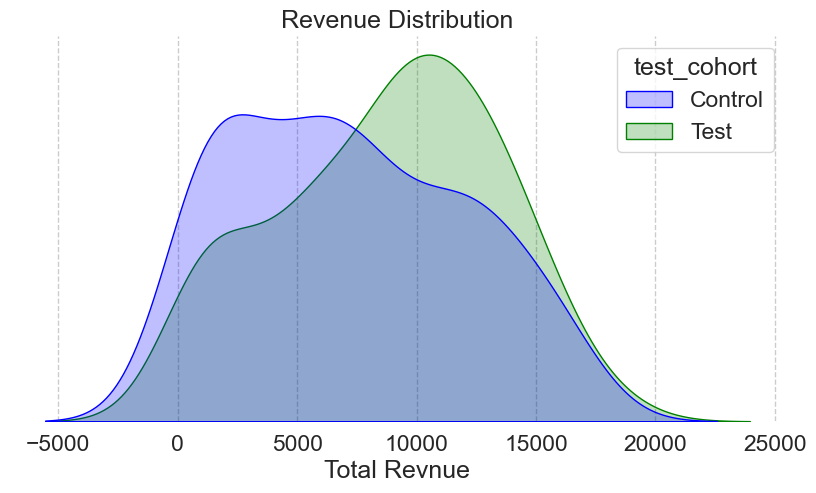

In [16]:
plots.plot_density(
    data=post_test, 
    x_col='revenue', 
    hue_col='test_cohort', 
    title='Revenue Distribution', 
    x_label='Total Revnue', 
    y_label='',
    colors=['blue', 'green'],
)

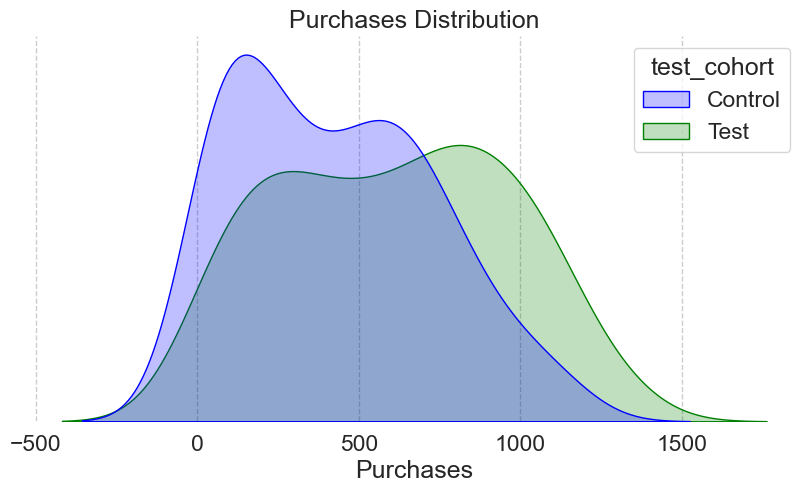

In [17]:
plots.plot_density(
    data=post_test, 
    x_col='purchases', 
    hue_col='test_cohort', 
    title='Purchases Distribution', 
    x_label='Purchases', 
    y_label='',
    colors=['blue', 'green'],
)

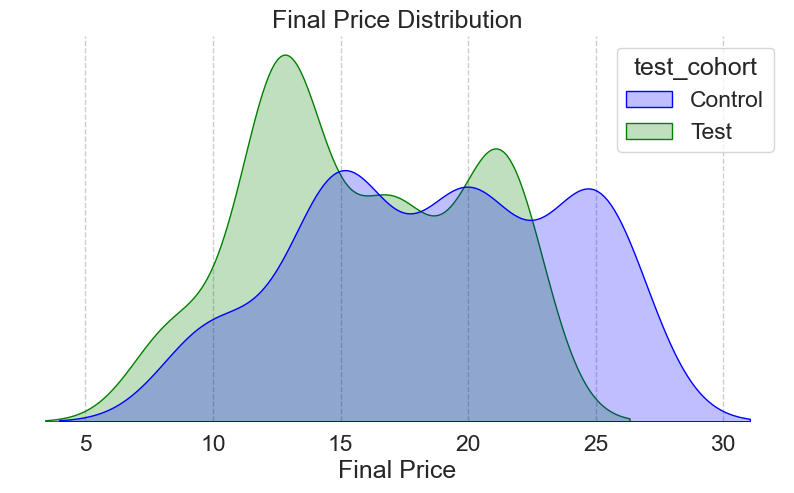

In [18]:
plots.plot_density(
    data=post_test, 
    x_col='final_price', 
    hue_col='test_cohort', 
    title='Final Price Distribution', 
    x_label='Final Price', 
    y_label='',
    colors=['blue', 'green'],
)

In [19]:
post_test.groupby(by=['test_cohort'])[['final_price']].mean()

,final_price
test_cohort,
Control,18.700
Test,15.725


## Elasticity

In [20]:
control_avg_revenue = post_test.query("test_cohort == 'Control'")['revenue'].mean()
test_avg_revenue = post_test.query("test_cohort == 'Test'")['revenue'].mean()

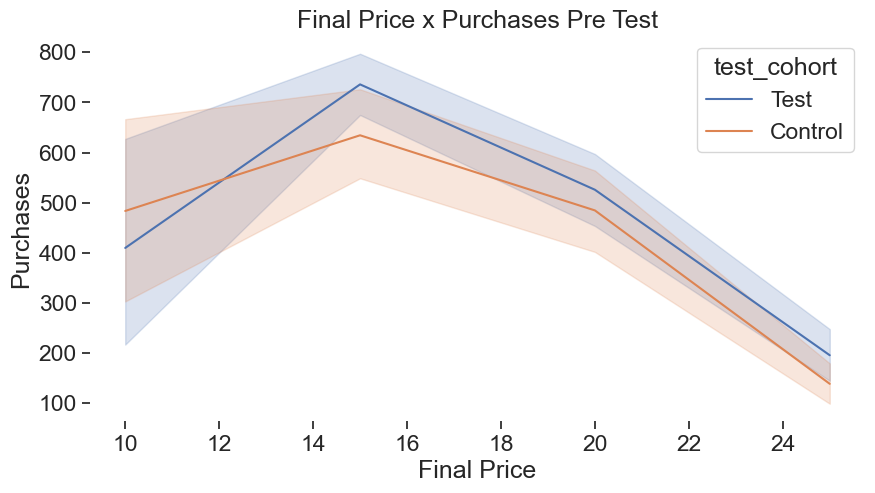

In [21]:
plots.plot_lineplot(
    df_plot=pre_test,
    x_col='final_price',
    y_col = 'purchases',
    hue_col='test_cohort',
    x_label='Final Price',
    y_label='Purchases',
    title='Final Price x Purchases Pre Test',
)

In [22]:
tmp = post_test.query("test_cohort=='Test'")
tmp[tmp['purchases']==tmp['purchases'].max()]

,company_id,period,test_cohort,pack_views,purchases,market_standard_pack_price,conversion_rate,offered_discount,final_price,revenue,is_test,pack_views_z_score,purchases_z_score
391,192,Post,Test,4417,1336,15,0.3,0.15,12.75,17034.0,1,-0.657575,2.044253


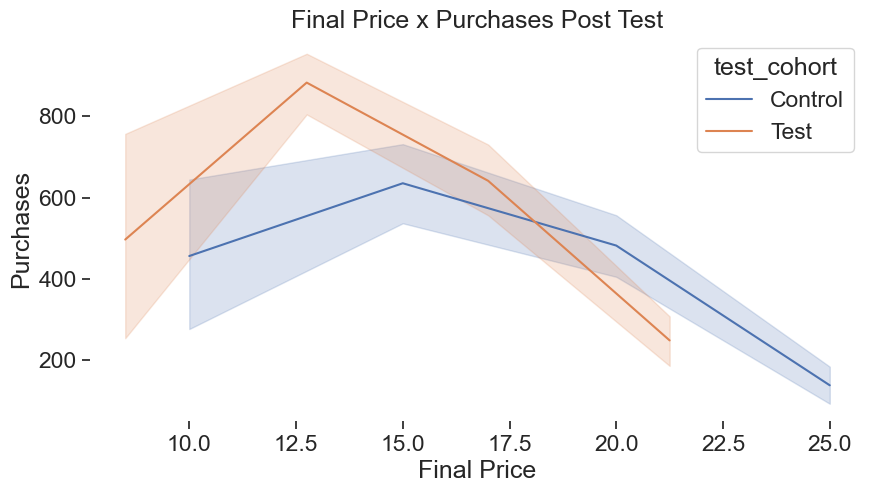

In [23]:
plots.plot_lineplot(
    df_plot=post_test,
    x_col='final_price',
    y_col = 'purchases',
    hue_col='test_cohort',
    x_label='Final Price',
    y_label='Purchases',
    title='Final Price x Purchases Post Test',
)

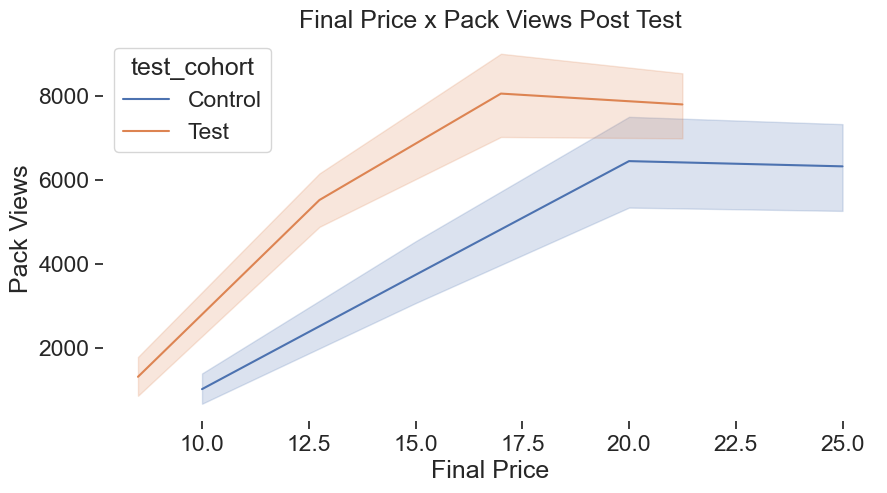

In [24]:
plots.plot_lineplot(
    df_plot=post_test,
    x_col='final_price',
    y_col = 'pack_views',
    hue_col='test_cohort',
    x_label='Final Price',
    y_label='Pack Views',
    title='Final Price x Pack Views Post Test',
)

In [25]:
control_x_pivot  = data.query("test_cohort == 'Control'").pivot(
    index=['company_id'],
    columns=['period'],
    values='final_price'
)

control_x_values = pd.DataFrame(control_x_pivot.to_records())

In [26]:
test_x_pivot  = data.query("test_cohort == 'Test'").pivot(
    index=['company_id'],
    columns=['period'],
    values='final_price'
)

test_x_values = pd.DataFrame(test_x_pivot.to_records())

In [27]:
control_y_pivot  = data.query("test_cohort == 'Control'").pivot(
    index=['company_id'],
    columns=['period'],
    values='purchases'
)

control_y_values = pd.DataFrame(control_y_pivot.to_records())

test_y_pivot  = data.query("test_cohort == 'Test'").pivot(
    index=['company_id'],
    columns=['period'],
    values='purchases'
)

test_y_values = pd.DataFrame(test_y_pivot.to_records())

In [28]:
def elasticity_report(x_values, y_values, p_value_threshold=0.20):
    points = []
    results_values = {
        "name": [],
        "price_elasticity": [],
        "price_mean": [],
        "quantity_mean": [],
        "intercept": [],
        "t_score":[],
        "slope": [],
        "coefficient_pvalue" : [],
        "rsquared": []
    }
    #Append x_values with control_y_values per same product name
    for column in x_values.columns[1:]:
        column_points = []
        for i in range(len(x_values[column])):
            if not np.isnan(x_values[column][i]) and not np.isnan(y_values[column][i]):
                column_points.append((x_values[column][i], y_values[column][i]))
        df = pd.DataFrame(list(column_points), columns= ['x_value', 'y_value'])

        #Linear Regression Model
        import statsmodels.api as sm
        x_value = df['x_value']
        y_value = df['y_value']
        X = sm.add_constant(x_value)
        model = sm.OLS(y_value, X)
        result = model.fit()
        
        
        #(Null Hypothesis test) Coefficient with a p value less than 0.05
        if result.f_pvalue <= p_value_threshold:
            
            rsquared = result.rsquared
            coefficient_pvalue = result.f_pvalue
            intercept, slope = result.params
            mean_price = np.mean(x_value)
            mean_quantity = np.mean(y_value)
            tintercept, t_score = result.tvalues
        
            #Price elasticity Formula
            price_elasticity = (slope)*(mean_price/mean_quantity)    
                
            #Append results into dictionary for dataframe
            results_values["name"].append(column)
            results_values["price_elasticity"].append(price_elasticity)
            results_values["price_mean"].append(mean_price)
            results_values["quantity_mean"].append(mean_quantity)
            results_values["intercept"].append(intercept)
            results_values['t_score'].append(t_score)
            results_values["slope"].append(slope)
            results_values["coefficient_pvalue"].append(coefficient_pvalue)
            results_values["rsquared"].append(rsquared)
            
    final_df = pd.DataFrame.from_dict(results_values)
    df_elasticity = \
        final_df[[
            'name',
            'price_elasticity',
            't_score',
            'coefficient_pvalue',
            'slope',
            'price_mean',
            'quantity_mean',
            'intercept',
            'rsquared'
        ]]
    
    return df_elasticity

In [29]:
control_elasticity = elasticity_report(control_x_values, control_y_values)
test_elasticity = elasticity_report(test_x_values, test_y_values)

In [30]:
control_elasticity

,name,price_elasticity,t_score,coefficient_pvalue,slope,price_mean,quantity_mean,intercept,rsquared
0,Post,-1.346431,-5.844840,6.654944e-08,-30.710154,18.700000,426.520000,1000.799881,0.258487
1,Pre,-1.400002,-6.356503,6.369684e-09,-31.926695,18.762376,427.871287,1026.891949,0.289840


In [31]:
test_elasticity

,name,price_elasticity,t_score,coefficient_pvalue,slope,price_mean,quantity_mean,intercept,rsquared
0,Post,-1.166477,-6.296339,8.636623e-09,-45.029352,15.725000,607.030000,1315.116566,0.288018
1,Pre,-1.189114,-6.439936,4.589491e-09,-32.486607,18.434343,503.626263,1102.495536,0.299501


A 10% price decrease, increases sales demand by 11.6%. A 10% price increase, decreases demand by 11.6%

A 15% price decrease, increases sales demand by 17.4%. A 15% price increase, decreases demand by 17.4%

A 25% price decrease, increases sales demand by 29%. A 25% price increase, decreases demand by 29%